### This code illustrates the learning algorithm for Dense Associative Memories from [Dense Associative Memory for Pattern Recognition](https://arxiv.org/abs/1606.01164) on MNIST data set.
If you want to learn more about Dense Associative Memories, check out a [NIPS 2016 talk](https://channel9.msdn.com/Events/Neural-Information-Processing-Systems-Conference/Neural-Information-Processing-Systems-Conference-NIPS-2016/Dense-Associative-Memory-for-Pattern-Recognition) or a [research seminar](https://www.youtube.com/watch?v=lvuAU_3t134). 

This cell loads the data and normalizes it to the [-1,1] range

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data from MAT File
mat = scipy.io.loadmat('mnist_all.mat')

In [3]:
# Input size = 28x28 pixels
N=784
#
# Number of Training Samples by Digit [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
NsTrainDigit=np.array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949], dtype='int')
# Number of Testing Samples by Digit [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
NsTestDigit=np.array([980, 1135, 1032, 1010, 982, 892, 958, 1028, 974, 1009], dtype='int')
#
# Classes to include
includeDigit=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype='int')
#
# Number of classes
Nc=np.count_nonzero(includeDigit == 1)
print(f"Number of classes: {Nc}")
#
# Number of Training Samples by class. -1 means all the samples
trainingSamplesByDigit=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype='int')
# Number of Testing Samples by class. -1 means all the samples
testingSamplesByDigit=np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype='int')
#
# Number of Total Training samples. -1 means sum of all samples of the digit.
# If -1 is not used, put the sum of the samples used.
Ns = 10000
if Ns == -1:
    Ns=NsTrainDigit[includeDigit==1].sum()
#   
# Number of Total Testing samples. -1 measn sum of all samples of the digit
# If -1 is not used, put the sum of the samples used.
NsT = 1000
if NsT == -1:
    NsT=NsTestDigit[includeDigit==1].sum()
#
# Row vector
M=np.zeros((0,N))
# Column vector
Lab=np.zeros((Nc,0))

Number of classes: 10


In [4]:
clsIdx = 0
for i, (included, nSamples) in enumerate(zip(includeDigit, trainingSamplesByDigit)):
    if included==1:
        if nSamples == -1:
            M=np.concatenate((M, mat['train'+str(i)]), axis=0)
            lab1=-np.ones((Nc,mat['train'+str(i)].shape[0]))
            lab1[clsIdx,:]=1.0
            Lab=np.concatenate((Lab,lab1), axis=1)
        else:
            M=np.concatenate((M, mat['train'+str(i)][:nSamples]), axis=0)
            lab1=-np.ones((Nc,mat['train'+str(i)][:nSamples].shape[0]))
            lab1[clsIdx,:]=1.0
            Lab=np.concatenate((Lab,lab1), axis=1)
        clsIdx += 1
M=2*M/255.0-1
M=M.T

In [5]:
# Generate tiled samples
if Ns != -1:
    M=np.tile(M, (1, int(Ns/M.shape[1])))
    Lab=np.tile(Lab, int(Ns/Lab.shape[1]))

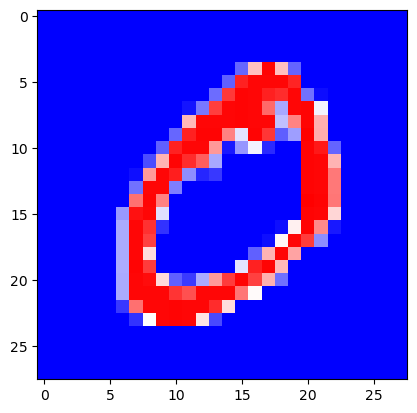

In [6]:
# Draw a digit
digito = M[:, 0].reshape((28,28))
plt.imshow(digito,cmap='bwr',vmin=-1,vmax=1)
plt.show()

In [7]:
# Row vector
MT=np.zeros((0,N))
# Column vector
LabT=np.zeros((Nc,0))

clsIdx = 0
for i, (included, nSamples) in enumerate(zip(includeDigit, testingSamplesByDigit)):
    if included==1:
        if nSamples == -1:
            MT=np.concatenate((MT, mat['test'+str(i)]), axis=0)
            lab1=-np.ones((Nc,mat['test'+str(i)].shape[0]))
            lab1[clsIdx,:]=1.0
            LabT=np.concatenate((LabT,lab1), axis=1)
        else:
            MT=np.concatenate((MT, mat['test'+str(i)][:nSamples]), axis=0)
            lab1=-np.ones((Nc,mat['test'+str(i)][:nSamples].shape[0]))
            lab1[clsIdx,:]=1.0
            LabT=np.concatenate((LabT,lab1), axis=1)
        clsIdx += 1
MT=2*MT/255.0-1
MT=MT.T

In [8]:
# Generate tiled samples
if NsT != -1:
    MT=np.tile(MT, (1, int(NsT/MT.shape[1])))
    LabT=np.tile(LabT, int(NsT/LabT.shape[1]))

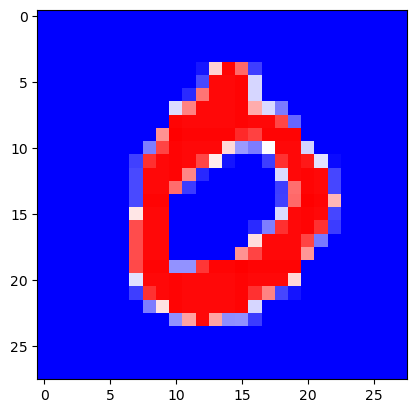

In [9]:
digito = MT[:, 0].reshape((28,28))
plt.imshow(digito,cmap='bwr',vmin=-1,vmax=1)
plt.show()

To draw a heatmap of the weights together with the errors on the training set (blue) and the test set (red) a helper function is created:

In [10]:
def draw_weights(synapses, Kx, Ky, err_tr, err_test):
    fig.clf()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    plt.sca(ax1)
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            # print(f'Ky:{Ky}, Kx:{Kx}, y:{y}, x:{x}, yy:{yy}, HM[{y*28}:{(y+1)*28}, {x*28}:{(x+1)*28}]')
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    cbar=fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    cbar.ax.tick_params(labelsize=30) 
    
    plt.sca(ax2)
    plt.ylim((0,100))
    plt.xlim((0,len(err_tr)+1))
    ax2.plot(np.arange(1, len(err_tr)+1, 1), err_tr, color='b', linewidth=4)
    ax2.plot(np.arange(1, len(err_test)+1, 1), err_test, color='r',linewidth=4)
    ax2.set_xlabel('Number of epochs', size=30)
    ax2.set_ylabel('Training and test error, %', size=30)
    ax2.tick_params(labelsize=30)

    plt.tight_layout()
    fig.canvas.draw()

This cell defines parameters of the algorithm: `n` - power of the rectified polynomial in [Eq 3](https://arxiv.org/abs/1606.01164); `m` - power of the loss function in [Eq 14](https://arxiv.org/abs/1606.01164); `K` - number of memories that are displayed as an `Ky` by `Kx` array by the helper function defined above; `eps0` - initial learning rate that is exponentially annealed during training with the damping parameter `f`, as explained in [Eq 12](https://arxiv.org/abs/1606.01164); `p` - momentum as defined in [Eq 13](https://arxiv.org/abs/1606.01164); `mu` - the mean of the gaussian distribution that initializes the weights; `sigma` - the standard deviation of that gaussian; `Nep` - number of epochs; `Num` - size of the training minibatch; `NumT` - size of the test minibatch; `prec` - parameter that controls numerical precision of the weight updates. Parameter `beta` that is used in [Eq 9](https://arxiv.org/abs/1606.01164) is defined as `beta=1/Temp**n`. The choice of temperatures `Temp` as well as the duration of the annealing `thresh_pret` is discussed in [Appendix A](https://arxiv.org/abs/1606.01164). 

In [ ]:
# Kx=2              # Number of memories per row on the weights plot
# Ky=2              # Number of memories per column on the weigths plot
# K=Kx*Ky            # Number of memories
# n=20               # Power of the interaction vertex in the DAM energy function
# m=30               # Power of the loss function
# eps0=4.0e-2        # Initial learning rate  
# f=0.998            # Damping parameter for the learning rate
# p=0.6              # Momentum
# Nep=300            # Number of epochs
# Temp_in=540.       # Initial temperature
# Temp_f=540.        # Final temperature
# thresh_pret=200    # Length of the temperature ramp
# Num=1000           # Size of training minibatch     
# NumT=1000          # Size of test minibatch 
# mu=-0.3            # Weights initialization mean
# sigma=0.3          # Weights initialization std
# prec=1.0e-30       # Precision of weight update

In [ ]:
# # OK
# Kx=2               # Number of memories per row on the weights plot
# Ky=1               # Number of memories per column on the weigths plot
# K=Kx*Ky            # Number of memories
# n=2                # Power of the interaction vertex in the DAM energy function
# m=1                # Power of the loss function
# eps0=4.0e-1        # Initial learning rate  
# f=0.998            # Damping parameter for the learning rate
# p=0.95             # Momentum
# Nep=300            # Number of epochs
# Temp_in=540.       # Initial temperature
# Temp_f=540.        # Final temperature
# thresh_pret=200    # Length of the temperature ramp
# Num=1000           # Size of training minibatch     
# NumT=1000          # Size of test minibatch 
# mu=-0.0            # Weights initialization mean
# sigma=0.3          # Weights initialization std
# prec=1.0e-30       # Precision of weight update

In [13]:
Kx=5               # Number of memories per row on the weights plot
Ky=2               # Number of memories per column on the weigths plot
K=Kx*Ky            # Number of memories
n=20               # Power of the interaction vertex in the DAM energy function
m=30               # Power of the loss function
eps0=4.0e-1        # Initial learning rate  
f=0.998            # Damping parameter for the learning rate
p=0.95             # Momentum
Nep=300            # Number of epochs
Temp_in=540.       # Initial temperature
Temp_f=540.        # Final temperature
thresh_pret=200    # Length of the temperature ramp
Num=1000           # Size of training minibatch     
NumT=1000          # Size of test minibatch 
mu=-0.0            # Weights initialization mean
sigma=0.3          # Weights initialization std
prec=1.0e-30       # Precision of weight update

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches.  The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch, see [Eq 13](https://arxiv.org/abs/1606.01164). The weights are displayed by the helper function after each epoch. 

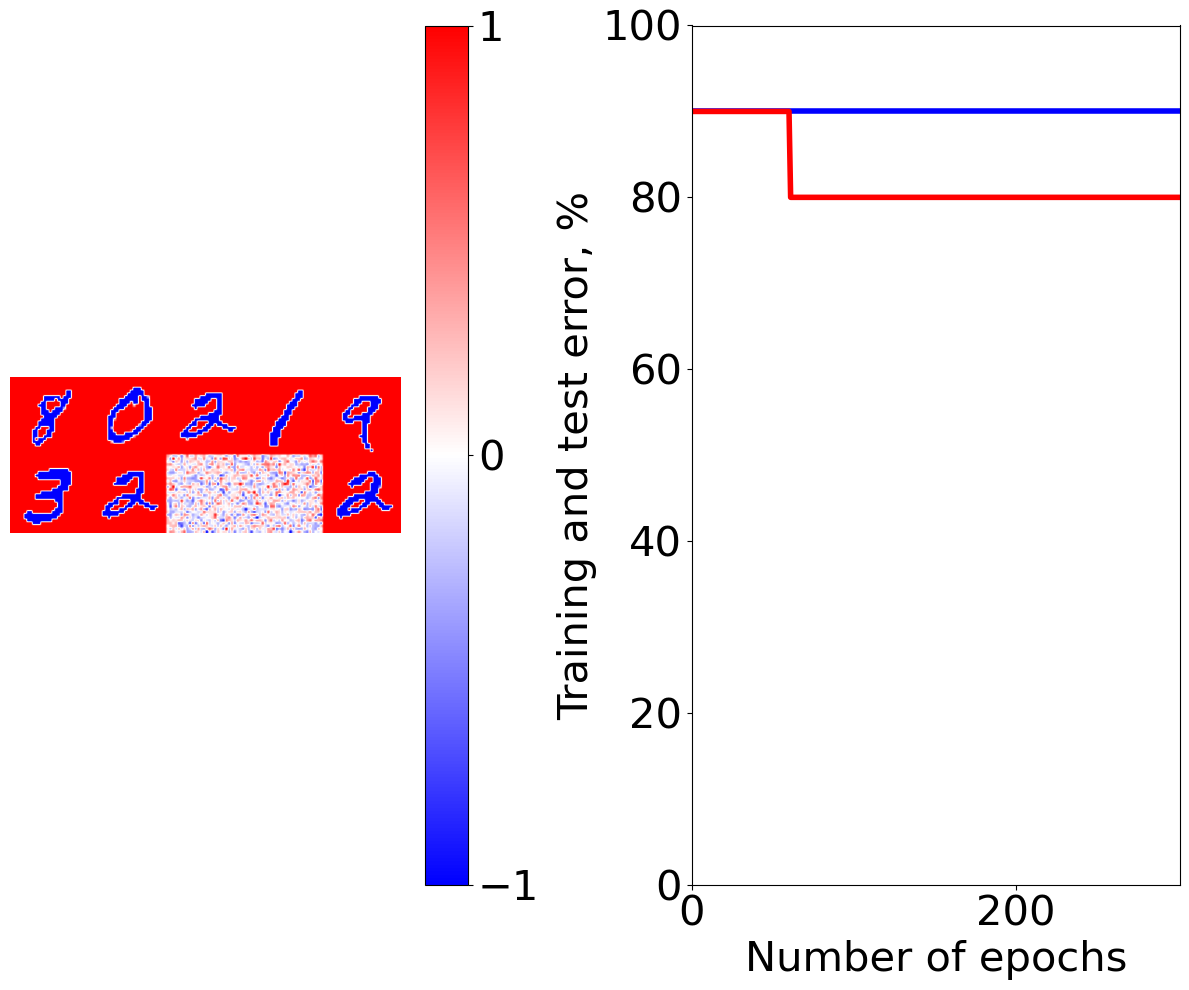

In [14]:
%matplotlib inline
# %matplotlib notebook
fig=plt.figure(figsize=(12,10))

KS=np.random.normal(mu, sigma, (K, N+Nc))
VKS=np.zeros((K, N+Nc))

aux=-np.ones((Nc,Num*Nc))
for d in range(Nc):
    aux[d,d*Num:(d+1)*Num]=1.

auxT=-np.ones((Nc,NumT*Nc))
for d in range(Nc):
    auxT[d,d*NumT:(d+1)*NumT]=1.
    
err_tr=[]
err_test=[]
for nep in range(Nep):
    eps=eps0*f**nep
    # Temperature ramp
    if nep<=thresh_pret:
        Temp=Temp_in+(Temp_f-Temp_in)*nep/thresh_pret
    else:
        Temp=Temp_f
    beta=1./Temp**n

    perm=np.random.permutation(Ns)
    M=M[:,perm]
    Lab=Lab[:,perm]
    num_correct = 0
    for k in range(Ns//Num):
        v=M[:,k*Num:(k+1)*Num]
        t_R=Lab[:,k*Num:(k+1)*Num]
        t=np.reshape(t_R,(1,Nc*Num))
        
        u=np.concatenate((v, -np.ones((Nc,Num))),axis=0)
        uu=np.tile(u,(1,Nc))
        vv=np.concatenate((uu[:N,:],aux),axis=0)
                
        KSvv=np.maximum(np.dot(KS,vv),0)
        KSuu=np.maximum(np.dot(KS,uu),0)
        
        Y=np.tanh(beta*np.sum(KSvv**n-KSuu**n, axis=0))  # Forward path, Eq 9
        Y_R=np.reshape(Y,(Nc,Num))
        
        #Gradients of the loss function
        d_KS=np.dot(np.tile((t-Y)**(2*m-1)*(1-Y)*(1+Y), (K,1))*KSvv**(n-1),vv.T) - np.dot(np.tile((t-Y)**(2*m-1)*(1-Y)*(1+Y), (K,1))*KSuu**(n-1),uu.T)
        
        VKS=p*VKS+d_KS
        nc=np.amax(np.absolute(VKS),axis=1).reshape(K,1)
        nc[nc<prec]=prec
        ncc=np.tile(nc,(1,N+Nc))
        KS += eps*VKS/ncc
        KS=np.clip(KS, a_min=-1., a_max=1.)
            
        correct=np.argmax(Y_R,axis=0)==np.argmax(t_R,axis=0)
        num_correct += np.sum(correct)
        
    err_tr.append(100.*(1.0-num_correct/Ns))
    
    num_correct = 0
    for k in range(NsT//NumT):
        v=MT[:,k*NumT:(k+1)*NumT]
        t_R=LabT[:,k*NumT:(k+1)*NumT]
        u=np.concatenate((v, -np.ones((Nc,NumT))),axis=0)
        uu=np.tile(u,(1,Nc))
        vv=np.concatenate((uu[:N,:],auxT),axis=0)
        KSvv=np.maximum(np.dot(KS,vv),0)
        KSuu=np.maximum(np.dot(KS,uu),0)
        Y=np.tanh(beta*np.sum(KSvv**n-KSuu**n, axis=0))  # Forward path, Eq 9
        Y_R=np.reshape(Y,(Nc,NumT))
        correct=np.argmax(Y_R,axis=0)==np.argmax(t_R,axis=0)
        num_correct += np.sum(correct)
    errr=100.*(1.0-num_correct/NsT)
    err_test.append(errr)
    draw_weights(KS[:,:N], Kx, Ky, err_tr, err_test)
